In [1]:
import sys
import numpy as np
import numba
from numba import prange
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

sys.path.append('../lib/')
from utils import *

%load_ext Cython

### Test data

In [2]:
Nc = 1000
Ne = 2*Nc

c = 0.25*np.random.random(Nc)
sig = np.ones(Nc)*0.05
mu_center = np.random.random((Nc,2))
mu_eval = np.random.random((Ne,2))
xc = mu_center[:,0]
yc = mu_center[:,1]
xe = mu_eval[:,0]
ye = mu_eval[:,1]

### 1.- First _naive_ implementation

In [3]:
u1 = gm_eval(c, sig, xc, yc, xe, ye)

In [4]:
tr1 = %timeit -o -n 100 gm_eval(c, sig, xc, yc, xe, ye)

52.9 ms ± 66.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


***

### 2.- Second implementation: Gaussian Truncation

In [5]:
neigh_indexes1, neigh_indexes_aux = compute_neighbors(mu_center, mu_eval, 5*np.max(sig))

In [6]:
u2 = gm_eval_fast(c,sig,xc,yc,xe,ye,neigh_indexes1,neigh_indexes_aux)

In [7]:
tr2 = %timeit -o -n 100 gm_eval_fast(c,sig,xc,yc,xe,ye,neigh_indexes1,neigh_indexes_aux)

9.62 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print("Speedup: {0}".format(tr1.average/tr2.average))

Speedup: 5.501489417613817


In [9]:
print("Infinity norm of u1-u2: {0} ".format(np.max(np.abs(u1-u2))))

Infinity norm of u1-u2: 1.1311722899254306e-05 


It can be further improved with bigger values of `maxsig`.

### 3.- _Naive_ + paralelization

In [10]:
from threading import Thread

In [11]:
@numba.jit(nopython=True, nogil=True)
def _gm_eval_thread(c, sig, xc, yc, xe, ye, sind, chunk_size, res):
    n = len(xc)
    for i in range(sind,sind+chunk_size):
        for j in range(n):
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            res[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
            
def gm_eval_thread(c, sig, xc, yc, xe, ye, n_thread=2):
    # array for results
    Ne = len(xe)
    res = np.zeros(Ne)
    
    # data size for each thread
    chunk_size = Ne // n_thread
    
    # starting index for each thread
    start_indexes = [i * chunk_size for i in range(n_thread)]
    
    threads = [Thread(target=_gm_eval_thread, 
                  args=(c,sig,xc,yc,xe,ye,sind,chunk_size,res)) for sind in start_indexes]
    for thread in threads: thread.start()
    for thread in threads: thread.join()
        
    return res

In [12]:
u3 = gm_eval_thread(c, sig, xc, yc, xe, ye, n_thread=4)

In [13]:
tr3 = %timeit -o -n 100 gm_eval_thread(c, sig, xc, yc, xe, ye, n_thread=4)

16.2 ms ± 306 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
print("Speedup: {0}".format(tr1.average/tr3.average))

Speedup: 3.271372078880253


In [15]:
print("Infinity norm of u1-u3: {0} ".format(np.max(np.abs(u1-u3))))

Infinity norm of u1-u3: 0.0 


### 4.- figtree

In [16]:
from pyfigtree import figtree

In [17]:
# we set epsilon to match the error bound of the Gaussian truncation approach
u4 = figtree(mu_center, mu_eval, c, bandwidth=0.05, epsilon=1e-6)

In [18]:
%timeit -n 100 figtree(mu_center, mu_eval, c, bandwidth=0.05, epsilon=1e-5)

13.6 ms ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print("Infinity norm of u1-u5: {0} ".format(np.max(np.abs(u1-u4))))

Infinity norm of u1-u5: 1.5058086096043175 


## Parallelization of Gaussian Truncation approach

### 5.- Python threads

In [20]:
@numba.jit(nopython=True)
def _gm_eval_fast(c, sig, xc, yc, xe, ye, neigh_indexes, 
                 neigh_indexes_aux, _sind, chunk_size, ret):
    sind = 0 # start index
    if _sind!=0: sind = neigh_indexes_aux[_sind-1]
    for i in range(_sind,_sind+chunk_size):
        eind = neigh_indexes_aux[i] # end index
        for j in neigh_indexes[sind:eind]:
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            ret[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
        sind = eind


def gm_eval_thread_naive(c, sig, xc, yc, xe, ye, neigh_indexes,
                       neigh_indexes_aux, n_thread=2):
    # array for results
    Ne = len(xe)
    ret = np.zeros(Ne)
    
    # data size for each thread
    chunk_size = Ne // n_thread
    
    # starting index for each thread
    start_indexes = [i * chunk_size for i in range(n_thread)]
    
    threads = [Thread(target=_gm_eval_fast, 
                  args=(c,sig,xc,yc,xe,ye,neigh_indexes,neigh_indexes_aux,sind,chunk_size,ret)) for sind in start_indexes]
    for thread in threads: thread.start()
    for thread in threads: thread.join()
        
    return ret

In [23]:
u5 = gm_eval_thread_naive(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux, n_thread=4)

In [24]:
tr5 = %timeit -o -n 100 gm_eval_thread_naive(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux, n_thread=4)

10.3 ms ± 43.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print("Parallelization speedup: {0}".format(tr2.average/tr5.average))

Parallelization speedup: 0.9379773228705717


In [26]:
print("Total speedup: {0}".format(tr1.average/tr5.average))

Total speedup: 5.160272315734188


In [27]:
print("Infinity norm of u1-u5: {0} ".format(np.max(np.abs(u1-u5))))

Infinity norm of u1-u5: 1.1311722899254306e-05 


### 6.- Numba Paralelization

In [28]:
@numba.jit(nopython=True, parallel=True)
def gm_eval_thread_numba(c, sig, xc, yc, xe, ye, 
                neigh_indexes, neigh_indexes_aux):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in prange(m):
        if i==0: sind = 0
        else:    sind = neigh_indexes_aux[i-1]
        eind = neigh_indexes_aux[i] # end index
        for j in neigh_indexes[sind:eind]:
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            ret[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
    return ret

In [29]:
u6 = gm_eval_thread_numba(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux)

In [30]:
tr6 = %timeit -o -n 100 gm_eval_thread_numba(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux)

4.45 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print("Parallelization speedup: {0}".format(tr2.average/tr6.average))

Parallelization speedup: 2.162395671963385


In [32]:
print("Total speedup: {0}".format(tr1.average/tr6.average))

Total speedup: 11.896396906000481


In [33]:
print("Infinity norm of u1-u6: {0} ".format(np.max(np.abs(u1-u6))))

Infinity norm of u1-u6: 1.1311722899254306e-05 


### 7.- Numba paralelization 2

In [34]:
neigh_indexes2 = compute_neighbors2(mu_center, mu_eval, 5*np.max(sig))

In [35]:
@numba.jit(nopython=True, parallel=True)
def gm_eval_thread_numba2(c, sig, xc, yc, xe, ye, neigh_indexes):
    m = len(xe)
    ret = np.zeros(m)
    for i in prange(m):
        for j in neigh_indexes[i,:]:
            if j==-1: break
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            ret[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
    return ret

In [36]:
u7 = gm_eval_thread_numba2(c, sig, xc, yc, xe, ye, neigh_indexes2)

In [37]:
tr7 = %timeit -o -n 100 gm_eval_thread_numba2(c, sig, xc, yc, xe, ye, neigh_indexes2)

4.38 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print("Parallelization speedup: {0}".format(tr2.average/tr7.average))

Parallelization speedup: 2.1966928104964265


In [39]:
print("Total speedup: {0}".format(tr1.average/tr7.average))

Total speedup: 12.085082250694443


In [40]:
print("Infinity norm of u1-u6: {0} ".format(np.max(np.abs(u1-u7))))

Infinity norm of u1-u6: 1.1311722899254306e-05 


### 8.- Cython Paralelization 1

In [41]:
%%cython --compile-args=-O3 --compile-args=-ffast-math --compile-args=-march=native --compile-args=-fopenmp --link-args=-fopenmp
#cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True 
import numpy as np
from libc.math cimport exp
from cython.parallel import prange

def gm_eval_thread_cython(double[:] c, double[:] sig, double[:] xc, double[:] yc, double[:] xe,
                 double[:] ye, long[:] neigh_indexes, long[:] neigh_indexes_aux):
    cdef int m = xe.shape[0]
    cdef int i,j,sind,eind
    cdef double dist2
    cdef double[:] ret = np.zeros(m)
    
    for i in prange(m, nogil=True):
        if i==0: sind = 0
        else: sind = neigh_indexes_aux[i-1]
        eind = neigh_indexes_aux[i]
        for j in range(sind,eind):
            j = neigh_indexes[j]
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2
            ret[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
    return ret.base

In [43]:
u8 = gm_eval_thread_cython(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux)

In [53]:
tr8 = %timeit -o -n 1000 gm_eval_thread_cython(c, sig, xc, yc, xe, ye, neigh_indexes1, neigh_indexes_aux)

2.23 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
print("Parallelization speedup: {0}".format(tr2.average/tr8.average))

Parallelization speedup: 4.317682588872816


In [68]:
print("Total speedup: {0}".format(tr1.average/tr8.average))

Total speedup: 23.753685071299223


In [69]:
print("Infinity norm of u1-u8: {0} ".format(np.max(np.abs(u1-u8))))

Infinity norm of u1-u8: 1.1311722899254306e-05 


### 9.- Cython Paralelization 2

In [49]:
%%cython --compile-args=-O3 --compile-args=-ffast-math --compile-args=-march=native --compile-args=-fopenmp --link-args=-fopenmp
#cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True 
import numpy as np
from libc.math cimport exp
from cython.parallel import prange

def gm_eval_thread_cython2(double[:] c, double[:] sig, double[:] xc, double[:] yc, double[:] xe,
                 double[:] ye, long[:,:] neigh_indexes):
    cdef int m = neigh_indexes.shape[0]
    cdef int n = neigh_indexes.shape[1]
    cdef int i,j
    cdef double dist2 = 0
    cdef double[:] ret = np.zeros(m)
    
    for i in prange(m, nogil=True):
        for j in range(n):
            j = neigh_indexes[i,j]
            if j==-1: break
            dist2 = (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 
            ret[i] += c[j] * exp( -0.5 * dist2 / sig[j]**2 )
    return ret.base

In [50]:
u9 = gm_eval_thread_cython2(c, sig, xc, yc, xe, ye, neigh_indexes2)

In [54]:
tr9 = %timeit -o -n 1000 gm_eval_thread_cython2(c, sig, xc, yc, xe, ye, neigh_indexes2)

2.23 ms ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
print("Parallelization speedup: {0}".format(tr2.average/tr9.average))

Parallelization speedup: 4.320394002808339


In [65]:
print("Total speedup: {0}".format(tr1.average/tr9.average))

Total speedup: 23.768601886372274


In [66]:
print("Infinity norm of u1-u9: {0} ".format(np.max(np.abs(u1-u9))))

Infinity norm of u1-u9: 1.1311722899254306e-05 


***
## Time comparison

In [ ]:
times1 = []
times2 = []
times3 = []
n_points = list(range(250, 10001, 250))

for Nc in n_points:
    # points generation
    Ne = 2*Nc
    mu_center = np.random.random((Nc,2))
    mu_eval = np.random.random((Ne,2))
    c = 0.25*np.random.random(Nc)
    sig = np.ones(Nc)*0.05
    xc = mu_center[:,0]
    yc = mu_center[:,1]
    xe = mu_eval[:,0]
    ye = mu_eval[:,1]
    neigh_indexes,neigh_indexes_aux = compute_neighbors(mu_center, mu_eval, 5*np.max(sig))
    
    # evaluating performance of direct evaluation (naive)
    tr1 = %timeit -o -n 10 -q gm_eval(c, sig, xc, yc, xe, ye)
    times1.append(tr1.average)
    
    # evaluating performance of Gaussian truncation
    tr2 = %timeit -o -n 10 -q gm_eval_fast(c,sig,xc,yc,xe,ye,neigh_indexes,neigh_indexes_aux)
    times2.append(tr2.average)
    
    # evaluating performance of Gaussian truncation + paralelization
    tr3 = %timeit -o -n 10 -q gm_eval_thread_cython(c, sig, xc, yc, xe, ye, neigh_indexes, neigh_indexes_aux)
    times3.append(tr3.average)

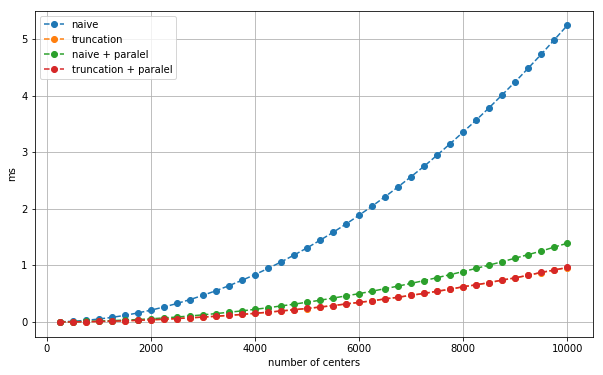

In [28]:
plt.figure(figsize=(10,6))
plt.plot(n_points, times1, "o--", label="naive")
plt.plot(n_points, times2, "o--", label="truncation")
plt.plot(n_points, times3, "o--", label="naive + paralel")
plt.grid()
plt.legend(loc="best")
plt.xlabel("number of centers")
plt.ylabel("ms")
plt.show()

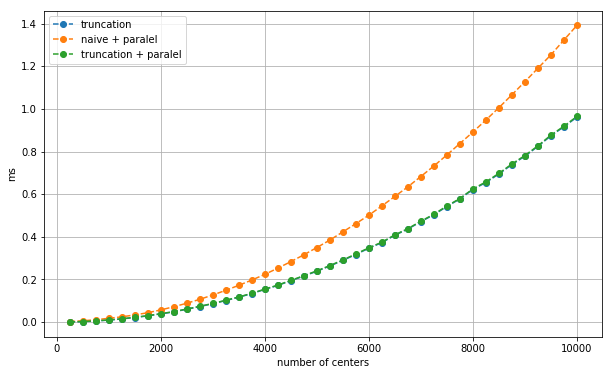

In [29]:
plt.figure(figsize=(10,6))
plt.plot(n_points, times2, "o--", label="truncation")
plt.plot(n_points, times3, "o--", label="naive + paralel")
plt.plot(n_points, times4, "o--", label="truncation + paralel")
plt.grid()
plt.legend(loc="best")
plt.xlabel("number of centers")
plt.ylabel("ms")
plt.show()

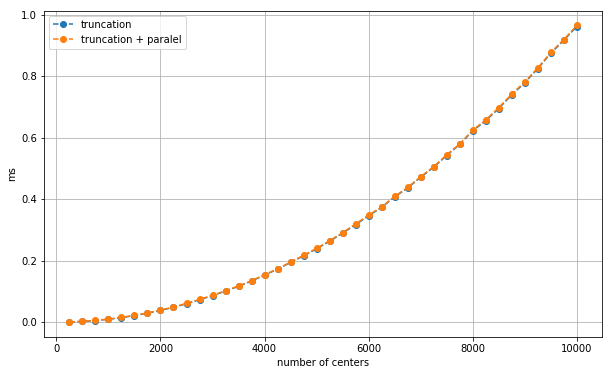

In [30]:
plt.figure(figsize=(10,6))
plt.plot(n_points, times2, "o--", label="truncation")
plt.plot(n_points, times4, "o--", label="truncation + paralel")
plt.grid()
plt.legend(loc="best")
plt.xlabel("number of centers")
plt.ylabel("ms")
plt.show()